In [1]:
import torch
from urllib.request import urlopen
from PIL import Image
from open_clip import create_model_from_pretrained, get_tokenizer
import glob
import os
import numpy as np


/local_scratch/mding3/anaconda3/envs/flta/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
import re
from pathlib import Path


In [ ]:

#read this file into in 
def extract_findings_and_impression(text: str) -> str:
    """
    Extract and concatenate the 'Findings' and 'Impression' sections from a radiology report.

    Sections are located by their headings (case-insensitive), and all text between each heading
    and the next ALL-CAPS heading (or end-of-text) is captured.
    """
    combined = []
    for section in ("FINDINGS", "IMPRESSION"):
        # Regex: match 'SECTION:' then lazily up to next all-caps heading ending with ':' or end of text
        pattern = rf"(?is){section}:(.*?)(?=\n[A-Z ]+?:|\Z)"
        match = re.search(pattern, text)
        if match:
            combined.append(match.group(1).strip())
    if len(combined) > 0:
      
        return " ".join(combined)
    if len(combined) == 0:
        return text.strip()


def split_and_filter_sentences(text: str, min_words: int = 3) -> list[str]:
    """
    Split text into sentences on ., !, or ? and remove any sentence with fewer than min_words words.
    """
    # Split on punctuation followed by whitespace
    sentences = re.split(r"(?<=[\.!?])\s+", text)
    # Filter out short sentences
    return [s.strip() for s in sentences if len(s.split()) >= min_words]


In [ ]:
import pandas as pd
front_file='*/front_postero_anterior_view_only.csv'
df_front = pd.read_csv(front_file)
for i, row in df_front.iterrows():
    study_id = row['study_id']
    subject_id = row['subject_id']
    df_front.at[i, 'filename'] = str(int(subject_id)) +'_'+str(int(study_id)) 
df_front.head()

front_view_id= df_front['filename'].tolist()
front_view_id

['10000032_50414267',
 '10000032_53189527',
 '10000898_50771383',
 '10000898_54205396',
 '10000935_55697293',
 '10000935_56522600',
 '10000980_50985099',
 '10000980_54935705',
 '10000980_57861150',
 '10000980_58636672',
 '10000980_59988438',
 '10001038_58224503',
 '10001038_58224503',
 '10001176_53186264',
 '10001176_54684191',
 '10001176_54684191',
 '10001217_52067803',
 '10001401_51065211',
 '10001401_51065211',
 '10001401_55350604',
 '10001401_58747570',
 '10001851_59664767',
 '10001884_50279568',
 '10001884_50807032',
 '10001884_52060840',
 '10001884_53109065',
 '10001884_53268982',
 '10001884_53880659',
 '10001884_53894864',
 '10001884_54000534',
 '10001884_54579606',
 '10001884_54828594',
 '10001884_55333410',
 '10001884_55893591',
 '10001884_56308417',
 '10001884_56349965',
 '10001884_57166219',
 '10001884_57839849',
 '10001884_58350684',
 '10001884_58788638',
 '10001884_59066712',
 '10001884_59212874',
 '10001884_59635781',
 '10001884_59984865',
 '10002013_52163036',
 '10002013

In [ ]:

# Load the model and config files from the Hugging Face Hub
model, preprocess = create_model_from_pretrained('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
tokenizer = get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
model.eval()
df_predict=pd.DataFrame(columns=['filename','label'])

img_dir='/home/mding3/local_scratch/fl_summer/embeddings/image/img'
text_dir='/home/mding3/local_scratch/fl_summer/embeddings/text_files'
images=glob.glob(img_dir + '/*.jpg')
i=0




for image_path in images:

    base_name = image_path.split('/')[-1].split('.jpg')[0]
    text_path= os.path.join(text_dir, f"{base_name}.txt")  
    report_path = Path(text_path)

    # 2) Read the report text
    report_text = report_path.read_text(encoding="utf-8")

    # 3) Extract and combine Findings & Impression
    combined_text = extract_findings_and_impression(report_text)

    # 4) Split into sentences and filter
    sentences = split_and_filter_sentences(combined_text, min_words=3)
    text= " ".join(sentences)


    

    texts=['non lung opacity','with lung opacity']
    one_img=[image_path]


    context_length = 500

    images = torch.stack([preprocess(Image.open(img)) for img in one_img]).to(device)
    texts = tokenizer([l for l in texts], context_length=context_length).to(device)

    with torch.no_grad():
        image_features, text_features, logit_scale = model(images, texts)




        #text_features=text_features/ text_features.norm(dim=-1, keepdim=True)
        #image_features=image_features/ image_features.norm(dim=-1, keepdim=True)

        image_features = image_features.cpu().numpy()
        text_features = text_features.cpu().numpy()


        combined_features = np.concatenate([image_features, text_features], axis=1)
    #savfe the combined_features to a file
        output_dir='/home/mding3/local_scratch/fl_summer/embeddings/img_text_embedding/medsiglip_448'
        os.makedirs(output_dir, exist_ok=True)
        output_file = os.path.join(output_dir, f"{base_name}.npy")
        np.save(output_file, combined_features)

1
0
1
1
1
2
1
3
1
4
1
5
1
6
1
7
0
8
0
9
0
10
1
11
1
12
1
13
1
14
1
15
0
16
0
17
0
18
1
19
1
20
0
21
1
22
0
23
1
24
1
25
1
26
0
27
0
28
1
29
1
30
0
31
1
32
1
33
1
34
1
35
0
36
1
37
0
38
1
39
1
40
1
41
1
42
1
43
1
44
1
45
1
46
0
47
0
48
1
49
1
50
0
51
0
52
1
53
0
54
1
55
1
56
1
57
1
58
1
59
0
60
0
61
1
62
0
63
0
64
0
65
1
66
0
67
0
68
0
69
0
70
0
71
0
72
1
73
0
74
1
75
1
76
0
77
1
78
1
79
1
80
1
81
1
82
1
83
1
84
1
85
1
86
1
87
0
88
0
89
0
90
1
91
1
92
1
93
0
94
0
95
1
96
0
97
1
98
1
99
0
100
0
101
1
102
0
103
1
104
1
105
1
106
0
107
1
108
1
109
0
110
1
111
1
112
0
113
1
114
0
115
1
116
0
117
0
118
1
119
0
120
1
121
0
122
1
123
0
124
1
125
0
126
1
127
0
128
1
129
1
130
1
131
0
132
1
133
1
134
0
135
1
136
1
137
1
138
1
139
0
140
1
141
1
142
1
143
0
144
0
145
0
146
0
147
0
148
1
149
0
150
0
151
1
152
1
153
1
154
1
155
0
156
1
157
0
158
0
159
0
160
1
161
0
162
0
163
1
164
0
165
0
166
1
167
1
168
1
169
1
170
1
171
1
172
1
173
1
174
0
175
0
176
0
177
1
178
0
179
0
180
1
181
0
182
1
183
0
184


In [18]:
import pandas as pd
df_file='/home/mding3/local_scratch/fl_summer/embeddings/Fusioned_emb-20250716T130653Z-1-001/Fusioned_emb/fused_clip_embeddings.csv'
df= pd.read_csv(df_file)  # Assuming the first column is an index
df['filename']= df['filename'].apply(lambda x: x.split('.jpg')[0])  # Extract filename from path
df.head()
#drop the 514th column
df = df.drop(columns=['clip_textimg_512'], errors='ignore')
df.head()

,filename,label,clip_textimg_0,clip_textimg_1,clip_textimg_2,clip_textimg_3,clip_textimg_4,clip_textimg_5,clip_textimg_6,clip_textimg_7,...,clip_textimg_1015,clip_textimg_1016,clip_textimg_1017,clip_textimg_1018,clip_textimg_1019,clip_textimg_1020,clip_textimg_1021,clip_textimg_1022,clip_textimg_1023,clip_textimg_1024
0,11455795_51725874,1,0.021438,-0.019331,-0.032344,0.021730,-0.018725,0.019592,0.035797,0.012274,...,-0.025573,-0.025673,0.029781,0.009823,-0.005780,0.027950,0.001419,0.017790,0.011800,0.011325
1,16566006_52222511,0,0.030017,-0.026958,-0.043869,0.028176,-0.011436,0.031235,0.048427,-0.002976,...,-0.005235,-0.023003,0.017412,0.012552,-0.015273,0.044173,-0.009670,0.037230,-0.001391,0.027789
2,15833413_55394451,1,0.037235,-0.018081,-0.017373,0.007613,-0.008850,0.031490,0.029363,0.013109,...,-0.005001,-0.044499,0.023028,0.013787,-0.021833,0.016873,-0.011357,-0.004970,-0.000860,-0.002001
3,14939755_51235861,0,0.011449,-0.003647,-0.027924,0.013755,-0.013790,0.026038,0.038769,-0.002186,...,-0.031724,-0.015075,0.037618,-0.002753,-0.000654,0.030100,-0.007851,0.019700,0.011890,0.026998
4,11048450_58073569,1,0.007747,-0.016540,-0.026806,0.019183,-0.008619,0.035040,0.048577,-0.006388,...,-0.030842,-0.037651,0.030235,0.018578,-0.004773,0.028799,-0.012257,-0.028351,0.006128,0.025982


In [20]:
df_predict.rename(columns={'filename': 'filename', 'label': 'predicted_label'}, inplace=True)
df_predict.head()

,filename,predicted_label
0,15866669_55769226,1
1,16398746_55929500,1
2,19199746_51286889,1
3,17615451_50365908,1
4,13371198_54473263,1


In [23]:
#merge df_predict with df on filename 
df_merged = pd.merge(df, df_predict, on='filename', how='left')
df_merged.head()
#show me the percentage that label is same as predicted_label
percentage_same = (df_merged['label'] == df_merged['predicted_label']).mean() * 100
print(f"Percentage of same labels: {percentage_same:.2f}%")

Percentage of same labels: 66.40%


In [25]:
#mkae the rest as X_test and use the same y
df_test = df_merged[~df['filename'].isin(train_df['filename'])]

In [26]:
percentage_same = (df_test['label'] == df_test['predicted_label']).mean() * 100
print(f"Percentage of same labels: {percentage_same:.2f}%")

Percentage of same labels: 66.16%


## classifiaction

In [18]:
df_test.shape

(2000, 1027)

In [24]:
import os
import numpy as np
import torch
import pandas as pd

# Configuration
exp_name='biomedclip_original_report'
emb_dir = f"/home/mding3/local_scratch/fl_summer/embeddings/img_text_embedding/{exp_name}"

embeddings = []
labels = []



import pandas as pd
df_file='/home/mding3/local_scratch/fl_summer/embeddings/Fusioned_emb-20250716T130653Z-1-001/Fusioned_emb/fused_clip_embeddings.csv'
df= pd.read_csv(df_file)  # Assuming the first column is an index
df['filename']= df['filename'].apply(lambda x: x.split('.jpg')[0])  # Extract filename from path
df.head()
#drop the 514th column
df = df.drop(columns=['clip_textimg_512'], errors='ignore')
df.head()
#make a arry based on the df, the label column is name label, and from 3rd colun to last aare differnt X
X = df.iloc[:, 2:].values  # Extract features
y = df['label'].values  # Extract labels
X.shape, y.shape
#
train_df='/home/mding3/local_scratch/fl_summer/summary/train_df.csv'
train_df = pd.read_csv(train_df)  # Assuming the first column is an index
for i, row in train_df.iterrows():
    study_id = row['study_id']
    subject_id = row['subject_id']
    train_df.at[i, 'filename'] = str(int(subject_id)) +'_'+str(int(study_id)) 
train_df.head()
df_all_train = pd.merge(df, train_df, on='filename', how='inner')
#remove the columns 'subject_id', 'study_id', 'Lung Opacity'
df_all_train = df_all_train.drop(columns=['subject_id', 'study_id', 'Lung Opacity'], errors='ignore')
df_all_train.head()

#mkae the rest as X_test and use the same y
df_test = df[~df['filename'].isin(train_df['filename'])]

def keep_front_view_only(df_input):

    front_file='/home/mding3/local_scratch/fl_summer/summary/front_postero_anterior_view_only.csv'
    df_front = pd.read_csv(front_file)
    for i, row in df_front.iterrows():
        study_id = row['study_id']
        subject_id = row['subject_id']
        df_front.at[i, 'filename'] = str(int(subject_id)) +'_'+str(int(study_id)) 
    df_front.head()

    front_view_id= df_front['filename'].tolist()
   
    df_input = df_input[~df_input['filename'].isin(front_view_id)]
    return df_input


df_all_train = keep_front_view_only(df_all_train)
df_test = keep_front_view_only(df_test)
train_df = keep_front_view_only(train_df)


In [26]:

embeddings = []
labels = []
for _, row in train_df.iterrows():
    study_id   = int(row['study_id'])
    subject_id = int(row['subject_id'])
    base_name  = f"{subject_id}_{study_id}"
    
    # Collect the label
    labels.append(row['Lung Opacity'])
    
    # Build the .pt filepath
    file_path = os.path.join(emb_dir, f"{base_name}.npy")
    if not os.path.exists(file_path):
        print(f"Warning: file not found: {file_path}")
        continue
    
    # Load the embedding
    embed = np.load(file_path, allow_pickle=True)
    embeddings.append(embed)
 

# Stack into a (n_samples, dim) array and build label array
X_train = np.vstack(embeddings)  # shape: (n_samples, embedding_dim)
y_train = np.array(labels)       # shape: (n_samples,)

print(f"Loaded {X_train.shape[0]} samples, each of dimension {X_train.shape[1]}")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)



embeddings = []
labels = []
for i, row in df_test.iterrows():
    filename = row['filename']
    filename = filename.split('.jpg')[0]  # Remove the .npy extension if present
    base_name  =filename
    
    # Collect the label
    labels.append(row['label'])
    # Build the .pt filepath
    file_path = os.path.join(emb_dir, f"{base_name}.npy")
    embed= np.load(file_path, allow_pickle=True)
    if not os.path.exists(file_path):
        print(f"Warning: file not found: {file_path}")
        continue
    
    # Load the embedding
    embeddings.append(embed)
# Stack into a (n_samples, dim) array and build label array
X_test = np.vstack(embeddings)  # shape: (n_samples, embedding_dim)
y_test = np.array(labels)       # shape: (n_samples,)

print(f"Loaded {X_test.shape[0]} samples, each of dimension {X_test.shape[1]}")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Loaded 957 samples, each of dimension 1024
X_train shape: (957, 1024)
y_train shape: (957,)
Loaded 412 samples, each of dimension 1024
X_test shape: (412, 1024)
y_test shape: (412,)


In [3]:
y_train.shape

(957,)

In [45]:
def logistic_regression_pipeline(X_train, y_train, X_test, y_test):

    from sklearn.preprocessing import MinMaxScaler, StandardScaler
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, roc_auc_score
    from sklearn.pipeline import Pipeline

    # Assume X_train, y_train, X_test, y_test are NumPy arrays already defined

    # 1) Build a preprocessing + classification pipeline
    # 1) Build a preprocessing + classification pipeline
    pipeline = Pipeline([


        ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
    ])

    # 2) Train on the training set
    pipeline.fit(X_train, y_train)

    # 3) Make predictions on the test set
    y_pred  = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]  # probability of the positive class

    # 4) Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc      = roc_auc_score(y_test, y_proba)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test ROC AUC : {auc:.4f}")

In [46]:

logistic_regression_pipeline(X_train[:,:512], y_train, X_test[:,:512], y_test)

Test Accuracy: 0.7063
Test ROC AUC : 0.7591


In [47]:
X_train_first=X_train.copy()
X_train_first[:,:512]=0
X_test_first=X_test.copy()
X_test_first[:,:512]=0

logistic_regression_pipeline(X_train_first, y_train, X_test_first, y_test)

Test Accuracy: 0.8010
Test ROC AUC : 0.8636


In [48]:
X_train_first=X_train.copy()
X_train_first[:,512:]=0
X_test_first=X_test.copy()
X_test_first[:,512:]=0

logistic_regression_pipeline(X_train_first, y_train, X_test_first, y_test)

Test Accuracy: 0.7063
Test ROC AUC : 0.7591


In [51]:
logistic_regression_pipeline(X_train, y_train, X_test, y_test)

Test Accuracy: 0.7961
Test ROC AUC : 0.8710


In [42]:
x_train_512 = X_train[:,:512]
x_train_last = X_train[:,512:]

x_test_512 = X_test[:,:512]
x_test_last = X_test[:,512:]
#element-wise multiplication
x_train = x_train_512 * x_train_last
x_test = x_test_512 * x_test_last

logistic_regression_pipeline(x_train, y_train, x_test, y_test)

Test Accuracy: 0.5607
Test ROC AUC : 0.5710


In [58]:
# 1) Min–Max normalize to [0, 1] using training‐set stats
X_min = X_train.min(axis=0)
X_max = X_train.max(axis=0)
# avoid division by zero
scale = (X_max - X_min)
scale[scale == 0] = 1.0

X_train_norm = (X_train - X_min) / scale
X_test_norm  = (X_test  - X_min) / scale

# 2) Standardize to zero mean, unit variance using training‐set stats
mean = X_train_norm.mean(axis=0)
std  = X_train_norm.std(axis=0)
std[std == 0] = 1.0

X_train = (X_train_norm - mean) / std
X_test = (X_test_norm  - mean) / std


In [52]:




import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_auc_score

import torch
from torch.utils.data import TensorDataset, DataLoader, random_split

# Assume you already have:
# X_train: np.ndarray of shape (N, 1024)
# y_train: np.ndarray of shape (N,)
# And you’ve done:
X_tensor = torch.from_numpy(X_train).float()
y_tensor = torch.from_numpy(y_train).float()

# 1) Wrap in a TensorDataset
dataset = TensorDataset(X_tensor, y_tensor)

# 2) Compute split sizes
val_ratio = 0.3
n_total = len(dataset)
n_val   = int(val_ratio * n_total)
n_train = n_total - n_val

# 3) Do the (deterministic) split
train_ds, val_ds = random_split(
    dataset,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(42)
)

# 4) Build DataLoaders
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size)

print(f"Train samples: {len(train_ds)}  |  Val samples: {len(val_ds)}")

X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_tensor, y_tensor), batch_size=32, shuffle=True)
test_loader  = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32)


# Model, loss, optimizer
class Net(nn.Module):
    def __init__(self):
        super().__init__()
       
        self.fc1 = nn.Linear(1024, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 1)
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
       
        return self.fc3(x).squeeze(1)

device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model     = Net().to(device)
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)


# —— Training with validation accuracy tracking ——
num_epochs = 200

# Lists for collecting metrics
metrics = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "val_acc": []
}

for epoch in range(1, num_epochs + 1):
    # --- Train phase ---
    model.train()
    total_train_loss = 0.0
    for xb, yb in train_loader:
        #xb[:,512:] = 0  # Zero out the second half of the input

        #element-wise multiplication
        xb[:, 512:] = 0

        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        logits = model(xb)
        loss   = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item() * xb.size(0)
    avg_train_loss = total_train_loss / n_train

    # --- Validation phase ---
    model.eval()
    total_val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb[:, 512:] = 0
            xb, yb = xb.to(device), yb.to(device)
            #xb[:, :512] = 0
            logits = model(xb)
            total_val_loss += criterion(logits, yb).item() * xb.size(0)
            preds = (torch.sigmoid(logits) >= 0.5).float()
            correct += (preds == yb).sum().item()

    avg_val_loss = total_val_loss / n_val
    val_acc      = correct / n_val

    # --- Log metrics ---
    metrics["epoch"].append(epoch)
    metrics["train_loss"].append(avg_train_loss)
    metrics["val_loss"].append(avg_val_loss)
    metrics["val_acc"].append(val_acc)

    print(
        f"Epoch {epoch:02d}/{num_epochs} | "
        f"Train Loss: {avg_train_loss:.4f} | "
        f"Val Loss: {avg_val_loss:.4f} | "
        f"Val Acc: {val_acc:.4f}"
    )

# —— After training, build a DataFrame for easy plotting/analysis ——
df_metrics = pd.DataFrame(metrics)

# You can now do things like:





Train samples: 670  |  Val samples: 287
Epoch 01/200 | Train Loss: 0.9972 | Val Loss: 0.6937 | Val Acc: 0.4774
Epoch 02/200 | Train Loss: 0.9917 | Val Loss: 0.6910 | Val Acc: 0.4774
Epoch 03/200 | Train Loss: 0.9862 | Val Loss: 0.6876 | Val Acc: 0.6690
Epoch 04/200 | Train Loss: 0.9798 | Val Loss: 0.6835 | Val Acc: 0.6167
Epoch 05/200 | Train Loss: 0.9725 | Val Loss: 0.6790 | Val Acc: 0.5993
Epoch 06/200 | Train Loss: 0.9643 | Val Loss: 0.6734 | Val Acc: 0.6098
Epoch 07/200 | Train Loss: 0.9553 | Val Loss: 0.6667 | Val Acc: 0.6237
Epoch 08/200 | Train Loss: 0.9448 | Val Loss: 0.6587 | Val Acc: 0.6446
Epoch 09/200 | Train Loss: 0.9335 | Val Loss: 0.6493 | Val Acc: 0.6620
Epoch 10/200 | Train Loss: 0.9210 | Val Loss: 0.6402 | Val Acc: 0.6620
Epoch 11/200 | Train Loss: 0.9091 | Val Loss: 0.6312 | Val Acc: 0.6794
Epoch 12/200 | Train Loss: 0.8978 | Val Loss: 0.6239 | Val Acc: 0.6725
Epoch 13/200 | Train Loss: 0.8869 | Val Loss: 0.6149 | Val Acc: 0.7108
Epoch 14/200 | Train Loss: 0.8761 | V

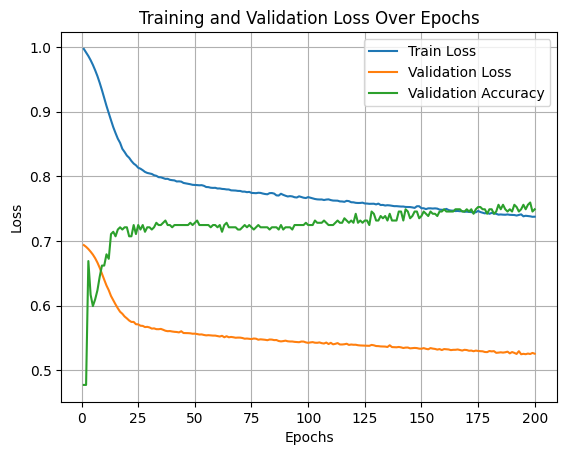

Test Accuracy: 0.6966
Test ROC AUC : 0.7578


In [54]:
#plotting the training loss
import matplotlib.pyplot as plt

#plot both train and validation losses  and val_acc from df_metrics
plt.plot(df_metrics['epoch'], df_metrics['train_loss'], label='Train Loss')
plt.plot(df_metrics['epoch'], df_metrics['val_loss'], label='Validation Loss')
plt.plot(df_metrics['epoch'], df_metrics['val_acc'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

# Evaluation on test set
model.eval()
y_true = []
y_scores = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb[:, 512:] = 0
        #xb1=xb[:,:512]
        #xb2=xb[:,512:]
        #element-wise multiplication

        xb = xb.to(device)

        logits = model(xb)
        probs = torch.sigmoid(logits)
        y_true.extend(yb.numpy())
        y_scores.extend(probs.cpu().numpy())

# Convert probabilities to binary predictions
y_pred = [1 if p >= 0.5 else 0 for p in y_scores]

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_scores)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test ROC AUC : {auc:.4f}")